In [1]:
## use in case missing interactive plt libr
%matplotlib inline   
     
from matplotlib import pylab as plt
import nglview

import ipywidgets as ipw
from IPython.display import display, clear_output, HTML

import ase
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view

import numpy as np

from rascal.representations import SphericalInvariants
from rascal.models import Kernel

## load a set of Al-O-N structures (traj.xyz) and the corresponding DFT energies (etotsorted.dat). Apply PBC to the structures and wrap atomic positions

In [2]:
# load the trajectory
framestot= read('traj.xyz',':')

# apply the PBC to the box
for i in framestot:
    i.pbc=True
    # Atoms should be wrapped within the cell, so let's just apply the PBC and wrap them
    i.wrap(eps=1e-11)
    
# load the corresponding total energies
entotfull=np.loadtxt("entotsorted.dat")

## Select N structures randomly from the set

In [3]:
# test it on a random sample
import random as rnd
from operator import itemgetter 

# get a random set, N structures
N=200
idrnd=np.asarray(rnd.sample(list(range(len(framestot))),N))
frames=list(itemgetter(*idrnd.tolist())(framestot))

# get the corresponding energies
entot=np.asarray(list(itemgetter(*idrnd.tolist())(entotfull)))

## make a map with kernel pca projection

In [4]:
# SOAP parameters

hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=3.5, 
              max_radial=6, 
              max_angular=6, 
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              )

# Define the model
soap = SphericalInvariants(**hypers)
kernel = Kernel(soap,name='Cosine', zeta=2, target_type='Structure', kernel_type='Full')

In [5]:
#Kernel?

In [6]:
# Compute the SOAPS 
managers = soap.transform(frames)

In [7]:
# and get the global similarity matrix (NxN matrix)
Kmat = kernel(managers)

In [8]:
Kmat[1][1]

0.4819099773615927

In [9]:
print(len(frames))

200


In [10]:
from sklearn.decomposition import KernelPCA

In [11]:
# apply the dimensionality reduction. Step 1: fit the model
kpca = KernelPCA(n_components=2,kernel='precomputed')
kpca.fit(Kmat)

KernelPCA(kernel='precomputed', n_components=2)

In [12]:
# Step 2 : project in low dimension the HD data using the kpca just trained
X = kpca.transform(Kmat)

In [13]:
print(len(X))

200


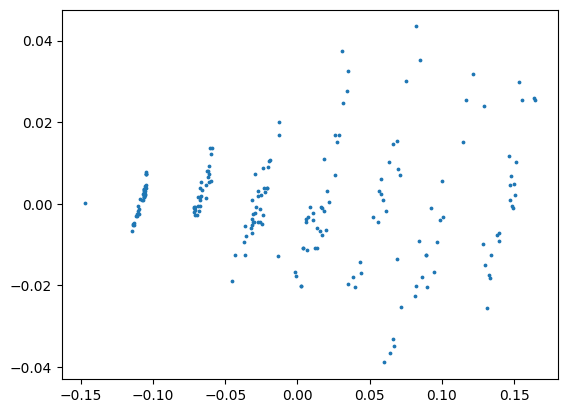

In [14]:
plt.scatter(X[:,0],X[:,1],s=3)

## plot selected frame

In [15]:
#frame=50
#plt.scatter(X[:,0],X[:,1],s=3)
#plt.scatter(X[frame,0],X[frame,1],s=3,c='red')
#a=view(frames[frame], viewer='ngl')

In [16]:
ou=ipw.Output()
idf=ipw.IntSlider(
    value=7,
    min=0,
    max=N-1,
    step=1,
    description='frame:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

display(idf,ou)

def on_frame_change(change):
    with ou:
        clear_output()
        val=idf.value
        plt.scatter(X[:,0],X[:,1],s=3)
        plt.scatter(X[val,0],X[val,1],s=5,c='red')
        plt.show()
        #display(view(frames[val], viewer='ngl'))
        v=view(frames[val], viewer='ngl')
        #v=_
        while hasattr(v.view, "component_0"):
            v.view.component_0.clear_representations()
            cid = v.view.component_0.id
            v.view.remove_component(cid)
        v.view.add_component(nglview.ASEStructure(frames[val]), 
                     default_representation=False)
        v.view.add_ball_and_stick(aspectRatio=2.0, opacity=1.0,component=0)
        v.view.add_unitcell()
        v.view.center() 
        display(v)
idf.observe(on_frame_change,names='value')

IntSlider(value=7, continuous_update=False, description='frame:', max=199)

Output()

## PLOT the cohesive energy on top of the map

## getnatms determines the number of Al,N,O for each frame

In [17]:
# get the partial numbers of atoms
def getnatms(frm):
    tmp=np.asarray([len(np.where(frm.get_atomic_numbers()==13)[0]),len(np.where(frm.get_atomic_numbers()==7)[0]),len(np.where(frm.get_atomic_numbers()==8)[0])])
    return tmp

## identify pure AlN and pure Al2O3 to compute cohesive energy. The supercell of AlN contains 96 formula units while the supercell of Al2O3 contains 48 formula units

In [18]:
# get ref energies
natms=np.asarray([getnatms(i) for i in framestot])
idxALN=np.where(natms[:,2]==0)
idxAL2O3=np.where(natms[:,1]==0)
enALN=entotfull[idxALN][0]/96.
enAL2O3=entotfull[idxAL2O3][0]/48.

In [19]:
# get the numbers just for the subset
natms=np.asarray([getnatms(i) for i in frames])
#idxALN=np.where(natms[:,2]==0)
#idxAL2O3=np.where(natms[:,1]==0)

## compute cohesive energy per atom  as $(E_{i} -n_N \mu _{AlN} - n_O \mu _{Al_2 O_3})/n_{atoms}$ 

In [20]:
def get_encoes(etot,ealn,eal2o3,atms):
    return (etot-atms[1]*ealn-atms[2]*eal2o3/3.)/atms.sum()

In [21]:
# get the coesive energy
ecoes=np.asarray([get_encoes(en,enALN,enAL2O3,natms[i]) for i,en in enumerate(entot)])

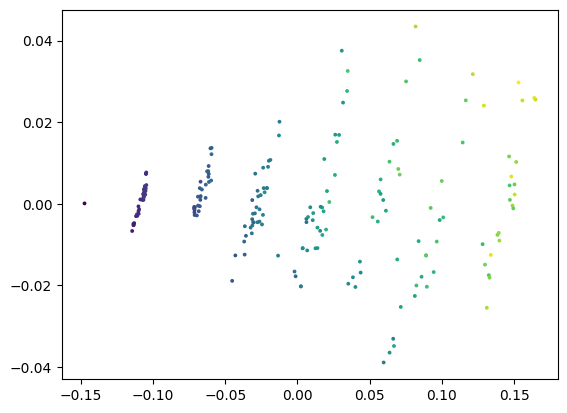

In [22]:
# color the points according to the coesive energy
plt.scatter(X[:,0],X[:,1],s=3,c=ecoes)

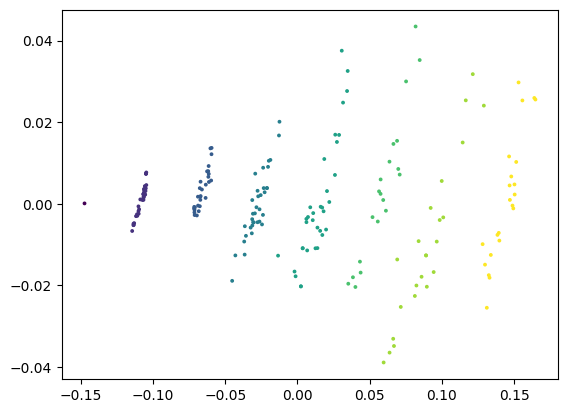

In [23]:
plt.scatter(X[:,0],X[:,1],s=3,c=natms[:,2])